In [1]:
import os
import re
import sys
from email import policy
from email.parser import Parser
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pol
import seaborn as sns
from nltk.tokenize import word_tokenize

In [2]:
df = pol.read_csv("../data/Vodafone_IDEA_data.csv")
df.head()

Incident_No,Description,Assigned_Group,Incident_Type,Production_Category,Operational_Category
str,str,str,str,str,str
"""INC00000776728…","""Please resolve…","""AskEvo""","""User Service R…","""Application_De…","""Issue_Applicat…"
"""INC00000776724…","""New Campaign |…","""CM Support""","""User Service R…","""Business Appli…","""Critical Appli…"
"""INC00000776689…","""CRM Applicatio…","""War Room""","""User Service R…","""Business Appli…","""Issue_Applicat…"
"""INC00000776650…","""Kindly do my o…","""Onboarding/Off…","""User Service R…","""Business Appli…","""SDP - CG_other…"
"""INC00000776602…","""vpn id not wor…","""Dispatcher""","""User Service R…","""Software_Opera…","""Issue_Access_F…"


In [3]:
df.shape

(50968, 6)

In [4]:
def extract_email_body(raw_email: str) -> str:
    """Function to extract the email body from the raw text"""
    email_parser = Parser(policy=policy.default)
    email_obj = email_parser.parsestr(raw_email)
    email_body = email_obj.get_body().get_content()
    return email_body


def clean_text(text: str) -> str:
    """Cleans email text by removing headers, footers, quoted text, signatures and additional text cleaning process"""

    # Removes Subject
    # text = re.sub(r"^.*?Subject:.*$", "", text, flags=re.MULTILINE)

    # Removes signatures
    text = re.sub(r"--\n.*", " ", text, flags=re.MULTILINE | re.DOTALL)

    # Removes HTML Tags
    text = re.sub(r"<.*?>", "", text)

    # Removes URLs
    text = re.sub(r"http[s]?://\S+", " ", text)

    # Removes email addresses
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", " ", text)

    # Normalize whitespace to a single space
    text = re.sub(r"[\n\s]+", " ", text).strip()

    # Convert to lowercase
    text = text.lower()

    return text


def get_n_words(text: str) -> int:
    """Function to obtain the number of words in a text"""
    text = extract_email_body(text)
    text = clean_text(text)
    words = word_tokenize(text)
    return len(words)

In [5]:
df = df.with_columns(
    (pol.col("Description").map_elements(lambda x: get_n_words(x))).alias("n_words")
)

df = df.with_columns(
    (
        pol.col("Description").map_elements(lambda x: clean_text(extract_email_body(x)))
    ).alias("clean_text")
)

In [6]:
df.null_count()

Incident_No,Description,Assigned_Group,Incident_Type,Production_Category,Operational_Category,n_words,clean_text
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


/home/darthvader/miniconda3/envs/expenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


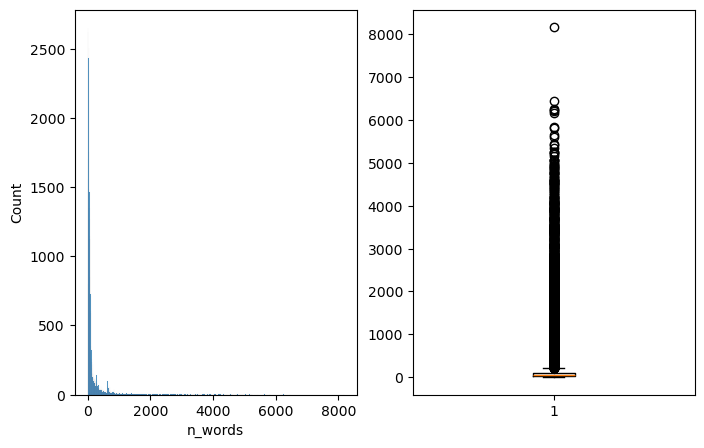

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes = axes.flatten()
sns.histplot(data=df, x="n_words", ax=axes[0])
axes[1].boxplot(df["n_words"].to_list())
plt.show()

In [8]:
mu = np.mean(df["n_words"].to_list())
std = np.std(df["n_words"].to_list())

threshold = mu + std

print(f"Threshold value: {threshold}")
print(f"Upper Quartile value: {np.quantile(df['n_words'].to_list(), .75)}")

Threshold value: 548.7595448125037
Upper Quartile value: 105.0


In [9]:
df_filtered = df.filter(
    pol.col("n_words") >= np.quantile(df["n_words"].to_list(), 0.75)
)

In [10]:
def fix_labels(label: str):
    """Function to remove extra spacing in labels"""
    label = label.lower()
    label = label.strip()
    label = re.sub(r"\s+", " ", label)
    label = re.sub(r"\s-\s", "-", label)
    label = re.sub(r"-\s", "-", label)
    label = re.sub(r"\s-", "-", label)
    label = re.sub(r"sso-support-.*", "sso-upport", label)
    label = re.sub(r"sso-opssupport-.*", "sso-opssupport", label)
    label = re.sub(r".*?-application support", "application support", label)
    label = re.sub(r"sso-unix?-.*", "sso-unix", label)
    label = re.sub(r"ro-.*", "ro", label)
    label = re.sub(r"zo-.*", "zo", label)
    label = re.sub(r"msc[+]zo?.*", "zo", label)
    label = re.sub(r"zo[+].*", "zo", label)
    label = re.sub(r"ro[+].*", "ro", label)
    label = re.sub(r".*eus-.*", "eus", label)
    label = re.sub(r".*network-.*", "network", label)
    label = re.sub(r"wh-.*", "wh", label)
    label = re.sub(r"ho-.*", "ho", label)

    if "rhythm" in label:
        label = label.replace("rhythm", "")

    if "jazz" in label:
        label = label.replace("jazz", "")

    if "blue" in label or "blues" in label:
        label = label.replace("blue", "").replace("blues", "")

    if "dispatcher" in label and label != "dispatcher":
        label = label.replace("dispatcher", "")

    if label.endswith("-"):
        label = label[:-1]

    return label

In [11]:
df_filtered = df_filtered.with_columns(
    (pol.col("Assigned_Group").map_elements(lambda x: fix_labels(x))).alias(
        "Assigned_Group_fixed"
    )
)

In [12]:
unique_labels = df_filtered["Assigned_Group_fixed"].unique().to_list()
len(unique_labels)

200

In [13]:
def filter_labels(labels: str, search_label: str) -> list:
    """Function to filter labels based on search labels"""

    return list(filter(lambda x: search_label in x, labels))

In [14]:
def freq_label_record(data: pol.DataFrame, label: str):
    """Function to obtain the frequency of a specific label"""
    n_rec = len(
        data.filter(pol.col("Assigned_Group_fixed").is_in([label]))[
            "Description"
        ].to_list()
    )
    return n_rec

/home/darthvader/miniconda3/envs/expenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


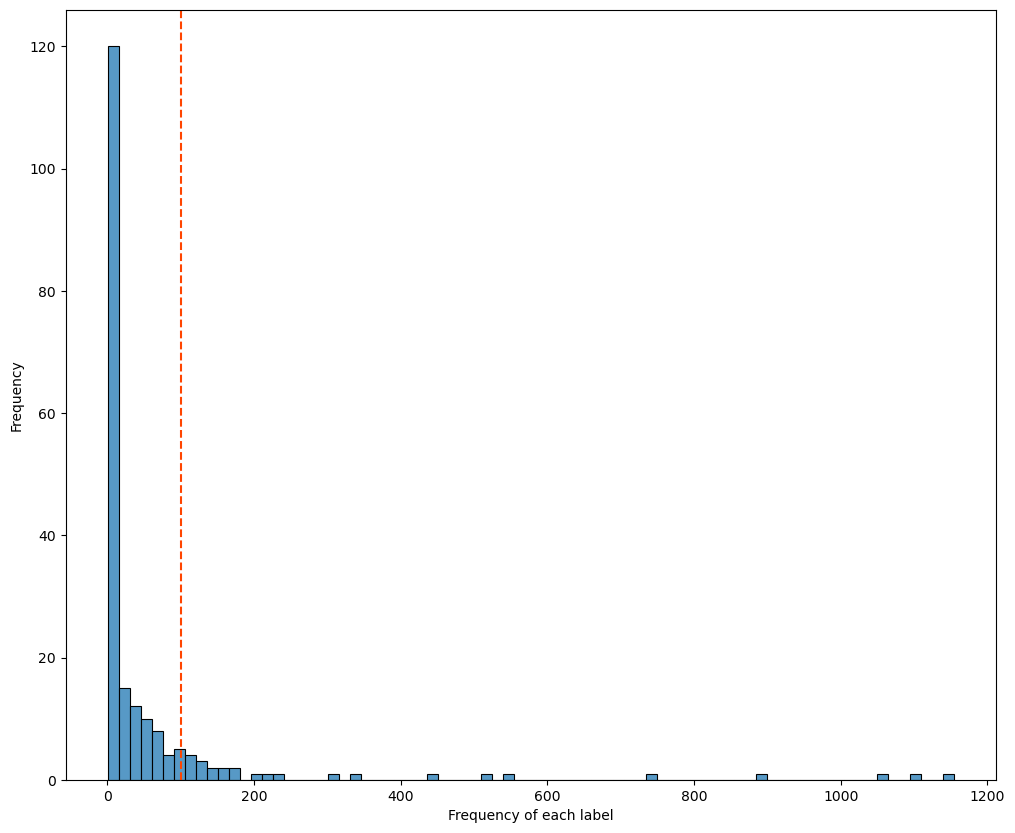

In [15]:
plt.figure(figsize=(12, 10))
sns.histplot(
    data=df_filtered, x=df_filtered["Assigned_Group_fixed"].value_counts()["counts"]
)
plt.axvline(x=100, color="orangered", label="100", linestyle="--")
plt.xlabel("Frequency of each label")
plt.ylabel("Frequency")
plt.show()

In [16]:
def get_stats_label_count(data: pol.DataFrame, quantiles: List):
    """Function to calculate the number of unique labels for each quantile value (Long-tail cutoff)"""

    value_counts = data["Assigned_Group_fixed"].value_counts()

    for quantile in quantiles:
        threshold_label_count = np.quantile(value_counts["counts"].to_list(), quantile)
        new_value_counts = value_counts.filter(
            pol.col("counts") >= threshold_label_count
        )
        labels = value_counts.filter(pol.col("counts") >= threshold_label_count)[
            "Assigned_Group_fixed"
        ].to_list()

        new_df = data.filter((pol.col("Assigned_Group_fixed").is_in(labels)))
        percent_of_data = new_df.shape[0] / data.shape[0] * 100

        print(
            f"Quantile: {quantile}, Threshold (label count): {threshold_label_count}, No. of Unique labels: {len(new_value_counts['Assigned_Group_fixed'].to_list())}, Percentage of Data: {percent_of_data:.3f}"
        )

In [17]:
get_stats_label_count(df_filtered, [0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

Quantile: 0.5, Threshold (label count): 10.5, No. of Unique labels: 100, Percentage of Data: 97.408
Quantile: 0.75, Threshold (label count): 47.0, No. of Unique labels: 51, Percentage of Data: 88.802
Quantile: 0.8, Threshold (label count): 64.80000000000007, No. of Unique labels: 40, Percentage of Data: 83.806
Quantile: 0.85, Threshold (label count): 93.30000000000001, No. of Unique labels: 30, Percentage of Data: 77.580
Quantile: 0.9, Threshold (label count): 123.39999999999998, No. of Unique labels: 20, Percentage of Data: 69.005
Quantile: 0.95, Threshold (label count): 234.04999999999862, No. of Unique labels: 10, Percentage of Data: 55.560
Quantile: 0.99, Threshold (label count): 1054.4399999999996, No. of Unique labels: 2, Percentage of Data: 17.635


In [18]:
value_counts = (
    df_filtered["Assigned_Group_fixed"]
    .value_counts()
    .sort(by="counts", descending=True)
)
value_counts.head()

Assigned_Group_fixed,counts
str,u32
"""cit-cpos-cposs…",1154
"""dispatcher""",1098
"""l1-crm postpai…",1054
"""security opera…",899
"""disha crm-crm-…",736


In [19]:
short_head_labels = value_counts.filter(pol.col("counts") >= 47)[
    "Assigned_Group_fixed"
].to_list()


df_short_head = df_filtered.filter(
    pol.col("Assigned_Group_fixed").is_in(short_head_labels)
)
df_long_tail = df_filtered.filter(
    ~pol.col("Assigned_Group_fixed").is_in(short_head_labels)
)

print(f"Shape of the Short-Head data: {df_short_head.shape}")
print(f"Shape of the Long-Tail data: {df_long_tail.shape}")

Shape of the Short-Head data: (11340, 9)
Shape of the Long-Tail data: (1430, 9)


In [20]:
df_short_head.write_csv(
    "../data/vodafone_data_short_head_long_emails.csv", separator=","
)
df_long_tail.write_csv("../data/vodafone_data_long_tail_long_emails.csv", separator=",")